In [ ]:
# The idea of using 2 kinds of losses is inspired by:
# # Earlier I trained using CrossEntropy lose resulting in 68% acc for 25 epochs.
# MultipleNegativesRankingLoss and Constructive loss resulted in better accuracy on my dataset, so using it.

# @inproceedings{reimers-2019-sentence-bert,
#     title = "Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks",
#     author = "Reimers, Nils and Gurevych, Iryna",
#     booktitle = "Proceedings of the 2019 Conference on Empirical Methods in Natural Language Processing",
#     month = "11",
#     year = "2019",
#     publisher = "Association for Computational Linguistics",
#     url = "https://arxiv.org/abs/1908.10084",
# }

# Original dataset was downloaded from https://quoradata.quora.com/First-Quora-Dataset-Release-Question-Pairs

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

QQ_model_path = "QQ_models"

In [3]:
os.chdir('/content/drive/MyDrive/Studies/NLP_PROJECT')

In [4]:
DATASET_COLUMNS_QQ =['id','qid1','qid2','q1','q2','is_duplicate']
DATASET_ENCODING = "ISO-8859-1"
org_dataset = pd.read_csv('quora_duplicate_questions.tsv',sep="\t", encoding=DATASET_ENCODING, names=DATASET_COLUMNS_QQ, usecols=['q1', 'q2', 'is_duplicate'], header=None)
my_dataset = pd.read_csv('MY_QQP_dataset.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS_QQ, usecols=['q1', 'q2', 'is_duplicate'], header=None)
# dataset = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS, usecols=[q1, q2, is_duplicate], header=Noneencoding=DATASET_ENCODING, names=DATASET_COLUMNS, usecols=['target', 'text'], header=None)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
print(org_dataset.head(), my_dataset.head())

                                                  q1  ...  is_duplicate
0                                          question1  ...  is_duplicate
1  What is the step by step guide to invest in sh...  ...             0
2  What is the story of Kohinoor (Koh-i-Noor) Dia...  ...             0
3  How can I increase the speed of my internet co...  ...             0
4  Why am I mentally very lonely? How can I solve...  ...             0

[5 rows x 3 columns]                                                   q1  ...  is_duplicate
0                                          question1  ...  is_duplicate
1  What was the name of the French company that i...  ...             1
2                  How does an alchemist gain magic?  ...             0
3                            What are we doing here?  ...             1
4  What is the name of the crater left by a meteo...  ...             0

[5 rows x 3 columns]


In [6]:
org_dataset.shape
org_dataset.info()
org_dataset.is_duplicate.unique()
print("\n"+"#"*80)
my_dataset.shape
my_dataset.info()
my_dataset.is_duplicate.unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404291 entries, 0 to 404290
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   q1            404290 non-null  object
 1   q2            404289 non-null  object
 2   is_duplicate  404291 non-null  object
dtypes: object(3)
memory usage: 9.3+ MB

################################################################################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7961 entries, 0 to 7960
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   q1            7961 non-null   object
 1   q2            7961 non-null   object
 2   is_duplicate  7961 non-null   object
dtypes: object(3)
memory usage: 186.7+ KB


array(['is_duplicate', '1', '0'], dtype=object)

In [7]:
print(org_dataset.isnull().sum())
print("\n"+"#"*80)
print(my_dataset.isnull().sum())

q1              1
q2              2
is_duplicate    0
dtype: int64

################################################################################
q1              0
q2              0
is_duplicate    0
dtype: int64


In [8]:
org_dataset = org_dataset.dropna()
org_dataset.isnull().sum()

q1              0
q2              0
is_duplicate    0
dtype: int64

In [9]:
org_dataset['is_duplicate'] = org_dataset['is_duplicate'].replace('0', 0)
org_dataset['is_duplicate'] = org_dataset['is_duplicate'].replace('1', 1)
my_dataset['is_duplicate'] = my_dataset['is_duplicate'].replace('0', 0)
my_dataset['is_duplicate'] = my_dataset['is_duplicate'].replace('1', 1)
org_dataset = org_dataset[1:]
my_dataset = my_dataset[1:]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
print(org_dataset.is_duplicate.unique())
print(my_dataset.is_duplicate.unique())

[0 1]
[1 0]


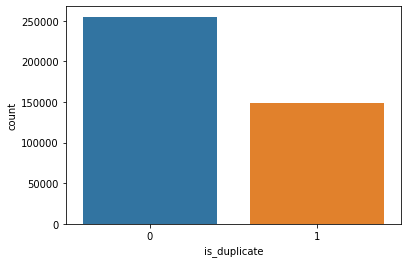

In [11]:
import seaborn as sns
sns.countplot(x='is_duplicate', data=org_dataset)

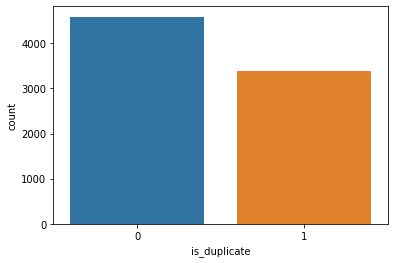

In [12]:
sns.countplot(x='is_duplicate', data=my_dataset)

In [19]:
# org_dataset = org_dataset.sample(7000)
# my_dataset = my_dataset.sample(7000)
from sklearn.model_selection import train_test_split
_, sampled_org_dataset = train_test_split(org_dataset, test_size=7000, stratify=org_dataset['is_duplicate'])
_, sampled_my_dataset = train_test_split(my_dataset, test_size=7000, stratify=my_dataset['is_duplicate'])
train_org_dataset, validation_org_dataset = train_test_split(sampled_org_dataset, train_size=0.8, stratify=sampled_org_dataset['is_duplicate'])
validation_org_dataset, test_org_dataset = train_test_split(validation_org_dataset, train_size=0.5, stratify=validation_org_dataset['is_duplicate'])
train_my_dataset, validation_my_dataset = train_test_split(sampled_my_dataset, train_size=0.8, stratify=sampled_my_dataset['is_duplicate'])
validation_my_dataset, test_org_datset = train_test_split(validation_my_dataset, train_size=0.5, stratify=validation_my_dataset['is_duplicate'])

In [20]:
train_org = "train_org.csv"
val_org = "val_org.csv"
test_org = "test_org.csv"
train_my = "my_train.csv"
val_my = "my_val.csv"

train_org_dataset.to_csv(os.path.join(QQ_model_path, train_org))
validation_org_dataset.to_csv(os.path.join(QQ_model_path, val_org))
test_org_dataset.to_csv(os.path.join(QQ_model_path, test_org))
train_my_dataset.to_csv(os.path.join(QQ_model_path, train_my))
validation_my_dataset.to_csv(os.path.join(QQ_model_path, val_my))

In [21]:
!pip install sentence-transformers

     |████████████████████████████████| 78 kB 5.0 MB/s 
     |████████████████████████████████| 3.1 MB 16.9 MB/s 
     |████████████████████████████████| 3.3 MB 59.8 MB/s 
     |████████████████████████████████| 1.2 MB 57.3 MB/s 
     |████████████████████████████████| 61 kB 533 kB/s 
     |████████████████████████████████| 596 kB 61.3 MB/s 
     |████████████████████████████████| 895 kB 58.6 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=80df80d07be0f1212f8f7f24b70251ebaf98e098cffe1ba105c93a774c5ba297
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [22]:
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation
from torch.utils.data import DataLoader
import csv

In [23]:
train_batch_size = 64
distance_metric = losses.SiameseDistanceMetric.COSINE_DISTANCE
margin = 0.5
num_epochs = 30

In [24]:
# Model for Orginal
org_model = SentenceTransformer('all-MiniLM-L12-v2')

train_samples_ConstrativeLoss = []
train_samples_MultipleNegativesRankingLoss = []
with open(os.path.join(QQ_model_path, train_org), 'r', newline='') as fr:
  csv_reader = csv.reader(fr)
  next(csv_reader)
  for _, q1, q2, is_duplicate in csv_reader:
    train_samples_ConstrativeLoss.append(InputExample(texts=[q1, q2], label=int(is_duplicate)))
    if is_duplicate == '1':
      train_samples_MultipleNegativesRankingLoss.append(InputExample(texts=[q1, q2], label=1))
      train_samples_MultipleNegativesRankingLoss.append(InputExample(texts=[q2, q1], label=1))

train_dataloader_MultipleNegativesRankingLoss = DataLoader(train_samples_MultipleNegativesRankingLoss, shuffle=True, batch_size=train_batch_size)
train_loss_MultipleNegativesRankingLoss = losses.MultipleNegativesRankingLoss(org_model)

train_dataloader_ConstrativeLoss = DataLoader(train_samples_ConstrativeLoss, shuffle=True, batch_size=train_batch_size)
train_loss_ConstrativeLoss = losses.OnlineContrastiveLoss(model=org_model, distance_metric=distance_metric, margin=margin)

#Tune the model
from sentence_transformers import evaluation
test_examples = []
with open(os.path.join(QQ_model_path, val_org), 'r', newline='') as fr:
  csv_reader = csv.reader(fr)
  next(csv_reader)
  for _, q1, q2, is_duplicate in csv_reader:
    test_examples.append(InputExample(texts=[q1, q2], label=float(is_duplicate)))

evaluator = evaluation.BinaryClassificationEvaluator.from_input_examples(test_examples, name="org_org")

org_model.fit(train_objectives=[(train_dataloader_MultipleNegativesRankingLoss, train_loss_MultipleNegativesRankingLoss), (train_dataloader_ConstrativeLoss, train_loss_ConstrativeLoss)], 
              epochs=num_epochs, warmup_steps=1000, evaluator=evaluator, 
              evaluation_steps=500, output_path=os.path.join(QQ_model_path, "double_org_prg_model"))

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/573 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/352 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/65 [00:00<?, ?it/s]

Iteration:   0%|          | 0/65 [00:00<?, ?it/s]

Iteration:   0%|          | 0/65 [00:00<?, ?it/s]

Iteration:   0%|          | 0/65 [00:00<?, ?it/s]

Iteration:   0%|          | 0/65 [00:00<?, ?it/s]

Iteration:   0%|          | 0/65 [00:00<?, ?it/s]

Iteration:   0%|          | 0/65 [00:00<?, ?it/s]

Iteration:   0%|          | 0/65 [00:00<?, ?it/s]

Iteration:   0%|          | 0/65 [00:00<?, ?it/s]

Iteration:   0%|          | 0/65 [00:00<?, ?it/s]

Iteration:   0%|          | 0/65 [00:00<?, ?it/s]

Iteration:   0%|          | 0/65 [00:00<?, ?it/s]

Iteration:   0%|          | 0/65 [00:00<?, ?it/s]

Iteration:   0%|          | 0/65 [00:00<?, ?it/s]

Iteration:   0%|          | 0/65 [00:00<?, ?it/s]

Iteration:   0%|          | 0/65 [00:00<?, ?it/s]

Iteration:   0%|          | 0/65 [00:00<?, ?it/s]

Iteration:   0%|          | 0/65 [00:00<?, ?it/s]

Iteration:   0%|          | 0/65 [00:00<?, ?it/s]

Iteration:   0%|          | 0/65 [00:00<?, ?it/s]

Iteration:   0%|          | 0/65 [00:00<?, ?it/s]

Iteration:   0%|          | 0/65 [00:00<?, ?it/s]

Iteration:   0%|          | 0/65 [00:00<?, ?it/s]

Iteration:   0%|          | 0/65 [00:00<?, ?it/s]

Iteration:   0%|          | 0/65 [00:00<?, ?it/s]

Iteration:   0%|          | 0/65 [00:00<?, ?it/s]

Iteration:   0%|          | 0/65 [00:00<?, ?it/s]

Iteration:   0%|          | 0/65 [00:00<?, ?it/s]

Iteration:   0%|          | 0/65 [00:00<?, ?it/s]

Iteration:   0%|          | 0/65 [00:00<?, ?it/s]

In [ ]:
# Model for My dataset
my_model = SentenceTransformer('all-MiniLM-L12-v2')

train_samples_ConstrativeLoss = []
train_samples_MultipleNegativesRankingLoss = []
with open(os.path.join(QQ_model_path, train_my), 'r', newline='') as fr:
  csv_reader = csv.reader(fr)
  next(csv_reader)
  for _, q1, q2, is_duplicate in csv_reader:
    train_samples_ConstrativeLoss.append(InputExample(texts=[q1, q2], label=int(is_duplicate)))
    if is_duplicate == '1':
      train_samples_MultipleNegativesRankingLoss.append(InputExample(texts=[q1, q2], label=1))
      train_samples_MultipleNegativesRankingLoss.append(InputExample(texts=[q2, q1], label=1))

train_dataloader_MultipleNegativesRankingLoss = DataLoader(train_samples_MultipleNegativesRankingLoss, shuffle=True, batch_size=train_batch_size)
train_loss_MultipleNegativesRankingLoss = losses.MultipleNegativesRankingLoss(my_model)

train_dataloader_ConstrativeLoss = DataLoader(train_samples_ConstrativeLoss, shuffle=True, batch_size=train_batch_size)
train_loss_ConstrativeLoss = losses.OnlineContrastiveLoss(model=my_model, distance_metric=distance_metric, margin=margin)

#Tune the model
from sentence_transformers import evaluation
test_examples = []
with open(os.path.join(QQ_model_path, val_my), 'r', newline='') as fr:
  csv_reader = csv.reader(fr)
  next(csv_reader)
  for _, q1, q2, is_duplicate in csv_reader:
    test_examples.append(InputExample(texts=[q1, q2], label=float(is_duplicate)))

evaluator = evaluation.BinaryClassificationEvaluator.from_input_examples(test_examples, name="my_my")

my_model.fit(train_objectives=[(train_dataloader_MultipleNegativesRankingLoss, train_loss_MultipleNegativesRankingLoss), (train_dataloader_ConstrativeLoss, train_loss_ConstrativeLoss)], 
              epochs=num_epochs, warmup_steps=1000, evaluator=evaluator, 
              evaluation_steps=500, output_path=os.path.join(QQ_model_path, "double_my_prg_model"))

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/75 [00:00<?, ?it/s]